# Differentiable Programming (with `jax`)

In [5]:
import jax
import jax.numpy as np
import jax.lax as lax
import matplotlib.pyplot as plt

In [1]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [2]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [3]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

## `jax` Basics

Almost all of the `numpy` API is implemented in `jax`. Arrays have a device that they are stored on. If you have a supported GPU, it will default to this, otherwise it'll go on the CPU (or a TPU if you're really fancy, but I've never used one). Note that there is the notion of a **platform** which includes `cpu`, `gpu`, and `tpu`. Each platform has a certain number of devices (often just one though).

In [6]:
# the output here will depend on your setup (we'll be using this "x" a lot below too)
x = np.array([1.0, 2.0, 3.0])
x.device()

CpuDevice(id=0)

In [8]:
# you can print out available devices
print(jax.devices('cpu'))
# print(jax.devices('gpu'))

[CpuDevice(id=0)]


In [9]:
# you can send data between devices
cpu0, *_ = jax.devices('cpu')
xc = jax.device_put(x, cpu0)
xc.device()

CpuDevice(id=0)

Arrays also have a `dtype`, which usually corresponds to those found in regular `numpy`. However, the defaults can be different and some are not supported on certain devices. The most common such difference is that `float64` is not supported unless you explicity enable it.

In [10]:
# create some arrays
print(np.arange(3).dtype)
print(np.arange(3, dtype='float32').dtype)
print(np.array([1, 2, 3]).dtype)
print(np.array([1.0, 2, 3]).dtype)
print(np.array([1, 2, 3], dtype='float32').dtype)

int32
float32
int32
float32
float32


In [11]:
# should still be all float32
print(x.dtype, x.astype('float64').dtype)
print(xc.dtype, xc.astype('float64').dtype)

float32 float32
float32 float32


You can enable `float64` by running: `jax.config.update('jax_enable_x64', True)`

### Scalar Operations With `grad`

Let's start with a scalar-to-scalar function derivatives. You can make a new function that returns the gradient by calling `grad` on a function.

In [12]:
# define a simple function (can be lambda too)
def f(x):
    return x**2
f(3.0)

9.0

In [13]:
# take the gradient (derivative)
df = jax.grad(f)
df(3.0)

DeviceArray(6., dtype=float32, weak_type=True)

In [14]:
# take the second derivative
d2f = jax.grad(df)
d2f(3.0)

DeviceArray(2., dtype=float32, weak_type=True)

In [15]:
# you need to make sure your inputs are floats
try:
    df(3)
except Exception as e:
    print(e)

grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.


Up until now, we've only looked at functions of one parameter. Going to many parameters is fine, we just need to tell `grad` which variable to take the derivative with respect to. We do this by specifying the index of the desired parameter or parameters in the `argnums` flag. If you give it multiple indices, it will return a list of derivatives. The default is `argnums=0`.

In [16]:
def g(x, y):
    return y*x**2 + x*y**3
dg = jax.grad(g, argnums=1)
dg(2.0, 3.0)

DeviceArray(58., dtype=float32, weak_type=True)

### Vector Operations With `grad` and `jacobian`

Now let's turn to vector-to-scalar functions. Here, calling `grad` will give you a function that returns a vector with the same size as the input dimension. You don't have to specify the dimensions to `jax`, it'll figure these out the first time the function actually gets called. Because of this, if `jax` isn't happy about something, it may not give you an error until you actually try to use the output of `grad`.

In [17]:
# the second term is just to add some complexity
def fv(x):
    return np.sum(x**2) + x[1]*x[2]
fv(x)

DeviceArray(20., dtype=float32)

In [18]:
# we use the "x" defined above as a test input
dfv = jax.grad(fv)
dfv(x)

DeviceArray([2., 7., 8.], dtype=float32)

In [19]:
# note that the jacobian is non-diagonal because of the additional term
jfv = jax.jacobian(dfv)
jfv(x)

DeviceArray([[2., 0., 0.],
             [0., 2., 1.],
             [0., 1., 2.]], dtype=float32)

In [21]:
# you can't use grad on vector-return functions! but maybe we can find another way...
try:
    dfe = jax.grad(lambda x: x**2)
    dfe(x)
except Exception as e:
    print(e)

Gradient only defined for scalar-output functions. Output had shape: (3,).


#### Vectorizing With `vmap`

Vectorization is often necessary for performance in Python, especially in `jax`. Fortunately, we can do this easily with `vmap`. This function will take a input function and map it along a new dimension of your choice. For instance, you can use it to turn a scalar-to-scalar function into a vector-to-vector function. But there are many more possibilities.

In [22]:
# the most basic usage on the "f" defined above
fv2 = jax.vmap(f)
fv2(x)

DeviceArray([1., 4., 9.], dtype=float32)

In [23]:
# now we can do the element-by-element gradient of a vector-return function
dfv2 = jax.vmap(jax.grad(f))
dfv2(x)

DeviceArray([2., 4., 6.], dtype=float32)

#### Just-In-Time Compilation With `jit`

This is an approach to speeding up code by compiling it just when it is needed (rather than beforehand, like in C or C++). It's used in JavaScript, MATLAB, and other places. Calling `jit` on a function will return another function that does the same thing but faster. 
As with `grad`, it only actually does the compilation when you run the

In [24]:
# compile the vector gradient function above
jdfv = jax.jit(dfv)
jdfv(x)

DeviceArray([2., 7., 8.], dtype=float32)

In [25]:
# give it a much bigger vector for testing
x2 = np.linspace(1.0, 5.0, 100000)

In [26]:
# first do the un-jit-ed version
%timeit -n 100 dfv(x2)

4.83 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
# now the jitted version (run twice for true comparison)
%timeit -n 100 jdfv(x2)

60.4 µs ± 6.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


On my computer this gives ~300x speed improvement. May vary from CPU to GPU though.

#### Trees in `jax`

Trees are very cool! They're basically arbitrarily nested `dict`s and `list`s whose leaves can be any type. If you've seen JSON before, it's very similar to that. Why are trees cool? Just as `numpy` lets you perform operations over an entire array at once, trees let you do the same over entire trees as well. This let's you avoid a lot of clunky and error-prone packing and unpacking.

In [30]:
# first let's define a very simple tree, which is just a dict of arrays
xd = {
    'x': np.linspace(1.0, 5.0, 5),
    'y': np.linspace(10.0, 19.0, 10),
}
xd

{'x': DeviceArray([1., 2., 3., 4., 5.], dtype=float32),
 'y': DeviceArray([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.], dtype=float32)}

In [31]:
# here's a function that operates on such a tree
# you could imagine specifying a model like this
# where the input is a dict of parameters or data points
def ft(d):
    xsum = np.sum(d['x']**3)
    ysum = np.sum(d['y']**2)
    return xsum + ysum

In [32]:
# now we can take a grad with respect to a tree and get a tree of the same shape back!
dft = jax.grad(ft)
dft(xd)

{'x': DeviceArray([ 3., 12., 27., 48., 75.], dtype=float32),
 'y': DeviceArray([20., 22., 24., 26., 28., 30., 32., 34., 36., 38.], dtype=float32)}

Sometimes it's easier to think in scalar terms them vectorize things. Suppose that our model really just operated on some `x` and `y` and we want to run the model for many such pairs. Then we can first define a slightly different function in purely scalar terms. I'm also adding in a separate parameter $\alpha$ to make things more interesting

In [33]:
def fts(d):
    x, y = d['x'], d['y']
    return x**3 + y**2

Then we use `vmap` to broadcast over the tree `d`. Below is what we'd write if we're interested in doing 10 distinct parameter sets.

In [34]:
xd1 = {'x': np.linspace(0, 1, 10), 'y': np.linspace(2, 3, 10)}
ftv1 = jax.vmap(fts)
ftv1(xd1)

DeviceArray([ 4.       ,  4.4581623,  4.949246 ,  5.481481 ,  6.0631013,
              6.702332 ,  7.4074063,  8.186558 ,  9.04801  , 10.       ],            dtype=float32)

But sometimes we just wany to vary one parameter at a time. As with `grad`, we need to tell it which dimensions to operate on, this time using `in_axes`. But it's a bit more complicated

In [35]:
xd2 = {'x': np.linspace(0, 1, 10), 'y': 2.0}
ftv2 = jax.vmap(fts, in_axes=({'x': 0, 'y': None},))
ftv2(xd2)

DeviceArray([4.       , 4.001372 , 4.010974 , 4.037037 , 4.0877914,
             4.171468 , 4.296296 , 4.4705076, 4.702332 , 5.       ],            dtype=float32)

Notice that `in_axes` is a list of the same length as the number of function arguments (in this case 1). We then have to mirror the structure of the tree itself to specify that we want to map `x` over axis 0 and not map `y` at all.

## Loops and Iteration

So... loops work a little differently in `jax`. It's okay to write a `for` loop actually, but not if you want to ultimately `jit` the thing. First, as we get into more advanced usage, there's a great overview of common "gotchas" in `jax` here: [JAX - The Sharp Bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html).

In [36]:
# very slow way to compute x**n
def fl(x, n):
    out = 1
    for i in range(n):
        out = x*out
    return out

In [37]:
try:
    jfl = jax.jit(fl)
    jfl(2.0, 3)
except Exception as e:
    print(e)

The __index__() method was called on the JAX Tracer object Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError


Not a very helpful error message! But basically we tried to use a function argument as the loop bounds and then `jit` it. One way to take care of this is to specify that `n` is mostly fixed using `static_argnums`. This will work but will recompile for each distinct value of `n` that is seen.

In [38]:
jfl = jax.jit(fl, static_argnums=1)
jfl(2.0, 3)

DeviceArray(8., dtype=float32, weak_type=True)

The other way is to use one of the looping tools from `lax` such as `scan` or `fori_loop`. First, let's try it using `fori_loop`

In [39]:
def fl_fori(x, n):
    fl_x = lambda i, v: x*v
    return lax.fori_loop(0, n, fl_x, 1)
jfl_fori = jax.jit(fl_fori)
jfl_fori(2.0, 3)

DeviceArray(8., dtype=float32)

## Optimization with JAX

Optimization typically involves looping in some way, so we need to be a bit careful when using `jax`. But you can achieve all of the same results with much more flexibility and speed at runtime. Here we're using simple gradient descent for opimization.

### Simple Function

In [35]:
# hardcoded step size
Δ = 0.1

In [36]:
# simple function
f = lambda x: -(x-1)**2 + 1
df = jax.grad(f)
vdf = jax.vmap(df)

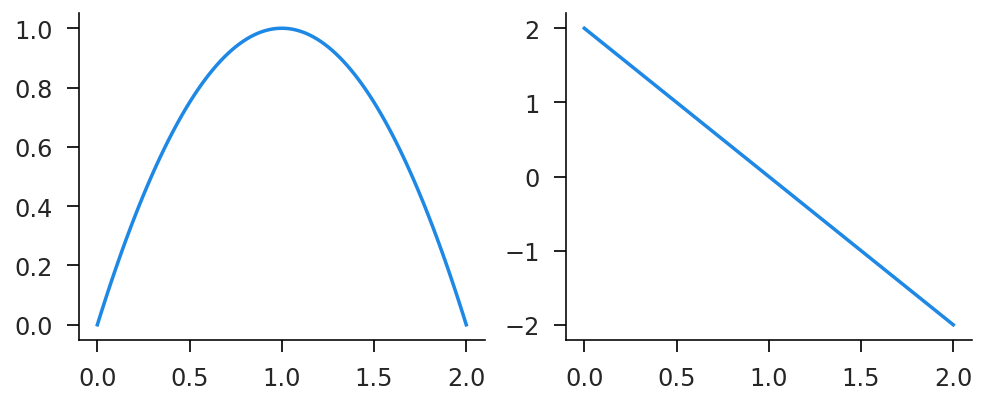

In [37]:
# visualize value and gradient
xgrid = np.linspace(0, 2, 100)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
ax0.plot(xgrid, f(xgrid))
ax1.plot(xgrid, vdf(xgrid));

In [38]:
# we define an update step function and one to apply it with scan
def update_scalar(x, t):
    xp = x + Δ*df(x)
    return xp, xp
def maximize_func(x0, K=50):
    tvec = np.arange(K) # this just has to be the right shape (K)
    x1, xvec = lax.scan(update_scalar, x0, tvec)
    return x1, xvec

In [39]:
# jit'ed scalar and vectorized versions
jmax_func = jax.jit(maximize_func)
vmax_func = jax.jit(jax.vmap(maximize_func))

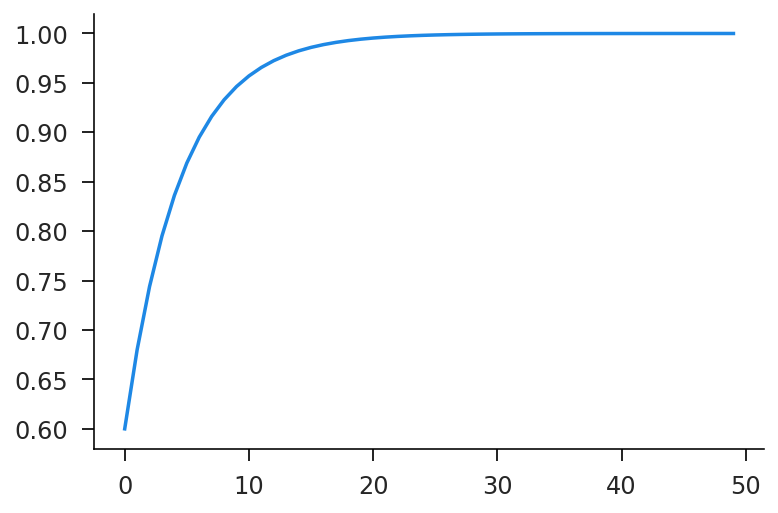

In [40]:
# run for just one starting value
x1, xvec = jmax_func(0.5)
plt.plot(xvec);

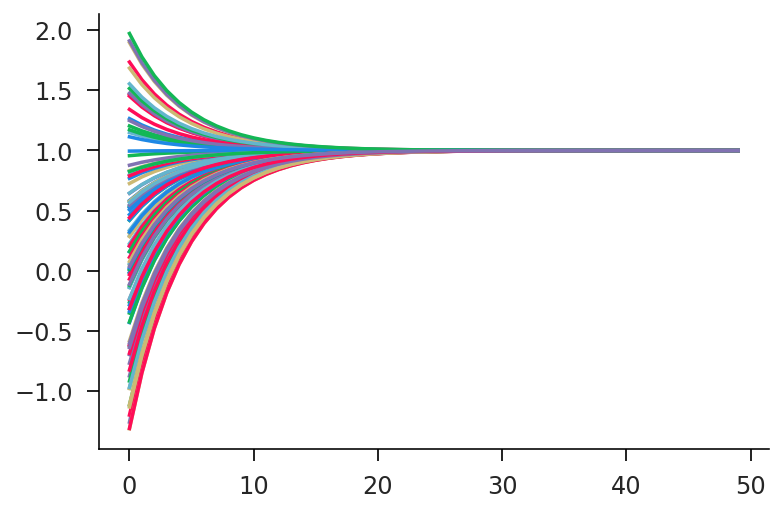

In [41]:
# run for many starting values simultaneously
# notice that random numbers work a bit different too
key = jax.random.PRNGKey(42)
xrand = jax.random.normal(key, (100,))
x1, xvec = vmax_func(xrand)
plt.plot(xvec.T);

### Parameterized

Now let's add in an additional parameter $\alpha$ which influences the optimization

In [42]:
# parameterized function (max=α)
f1 = lambda x, α: -(x-α)**2
df1 = jax.grad(f1)
vdf1 = jax.vmap(df1)

In [43]:
# we just need to apply α to function before optimizing
def update_scalar(α, x, t):
    xp = x + Δ*df1(x, α)
    return xp, xp
def maximize_func(α, x0, K=50):
    tvec = np.arange(K)
    upd = lambda x, t: update_scalar(α, x, t)
    x1, xvec = lax.scan(upd, x0, tvec)
    return x1, xvec

In [44]:
jmax_func = jax.jit(maximize_func)
vmax_func = jax.jit(jax.vmap(maximize_func, in_axes=(0, None)))

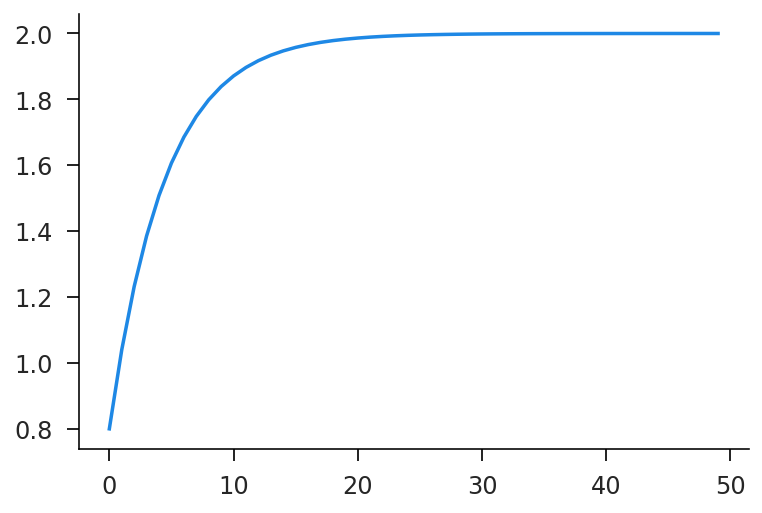

In [45]:
# run the scalar optimization for α = 2
x1, xvec = jmax_func(2.0, 0.5)
plt.plot(xvec);

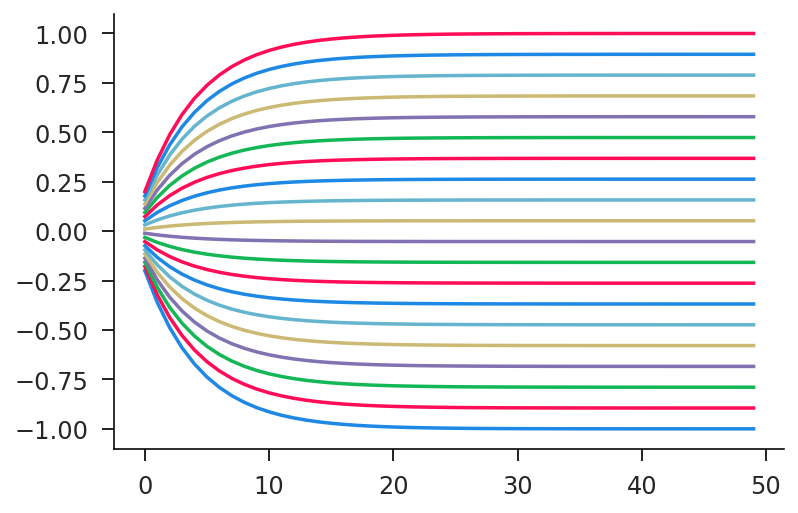

In [46]:
# run the optimization for a range of α's
αgrid = np.linspace(-1, 1, 20)
x1, xvec = vmax_func(αgrid, 0.0)
plt.plot(xvec.T);

We can even take the derivative of the optimal solution with respect to $\alpha$, which should always be $1$ in our case since $x^{\ast}(\alpha) = \alpha$.

In [47]:
dmax_func_out = jax.grad(lambda α, x0: maximize_func(α, x0)[0], argnums=0)
vmax_func_out = jax.vmap(dmax_func_out, in_axes=(0, None))
vmax_func_out(αgrid, 0.5)

DeviceArray([0.99998564, 0.99998564, 0.99998564, 0.99998564, 0.99998564,
             0.99998564, 0.99998564, 0.99998564, 0.99998564, 0.99998564,
             0.99998564, 0.99998564, 0.99998564, 0.99998564, 0.99998564,
             0.99998564, 0.99998564, 0.99998564, 0.99998564, 0.99998564],            dtype=float32)

## Value Functions With `jax`

Below is an implementation of simple value function iteration using `jax` for the neoclassical growth model. This makes use of trees for parameter values and the `scan` function for iteration. We start by defining parameters and the utility and production functions, as well as constructing the capital grid and finding the analytic steady state.

In [48]:
from functools import partial

In [49]:
# fixed params
T = 300 # time periods
N = 100 # grid size
f_lo, f_hi = 0.5, 2.0 # proportional grid range

In [50]:
# simple parameters
par0 = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
}

In [51]:
# find steady state
def get_kss(par):
    β, δ, z, α = par['β'], par['δ'], par['z'], par['α']
    rhs = (1-β)/β + δ
    k = (α*z/rhs)**(1/(1-α))
    return k
k_ss = get_kss(par0)

In [52]:
# construct capital grid
k_min = f_lo*k_ss
k_max = f_hi*k_ss
k_grid = np.linspace(k_min, k_max, N)

In [53]:
# defined functions
def util(c, ϵ=1e-6):
    c1 = np.maximum(ϵ, c)
    return np.log(c1)
def prod(k, z, α):
    return z*k**α

Now we define the actual updating rule and the outer solving function.

In [54]:
# the value function update function
def value(par, grid, st, tv):
    β = par['β']
    cp = grid['cp']
    vn = st['vn']

    # calculate optimal investment
    vp = util(cp) + β*vn[None,:]
    ip = np.argmax(vp, axis=1)
    vp = np.max(vp, axis=-1)

    # apply at values
    kp = k_grid[ip]
    
    # compute update errors
    err = np.max(np.abs(vp-vn))

    # return state and output
    stp = {
        'vn': vp,
    }
    out = {
        'v': vp,
        'kp': kp,
        'err': err,
    }
    
    return stp, out

In [55]:
# the actual solver (T is the number of iterations)
def solve(par, T):
    α = par['α']
    δ = par['δ']
    z = par['z']

    # precompute grid values
    y_grid = prod(k_grid, z, α)
    yd_grid = y_grid + (1-δ)*k_grid
    cp_grid = yd_grid[:,None] - k_grid[None,:]

    # partially apply grid
    grid = {
        'cp': cp_grid,
    }
    value1 = partial(value, par, grid)

    # scan over time (backwards)
    st0 = {
        'vn': util(y_grid),
    }
    tv = {
        't': np.arange(T)[::-1],
    }
    last, path = lax.scan(value1, st0, tv)

    return path

Now let's time the model and see how the results look!

In [56]:
# jit and run once to ensure compilation
jsolve = jax.jit(solve, static_argnums=(1,))
ret = jsolve(par0, T)

In [57]:
# get some timing numbers
%timeit -r 10 -n 10 jsolve(par0, T)

3.38 ms ± 383 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


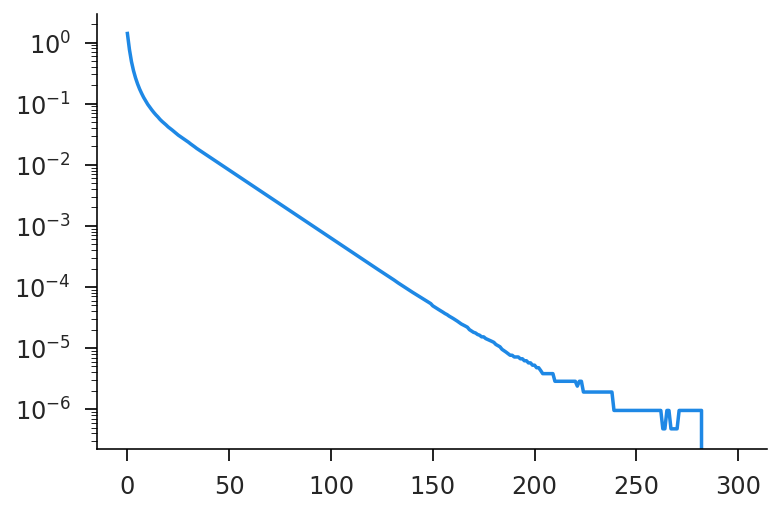

In [58]:
# plot the log error over the whole run
plt.plot(ret['err'])
plt.yscale('log');

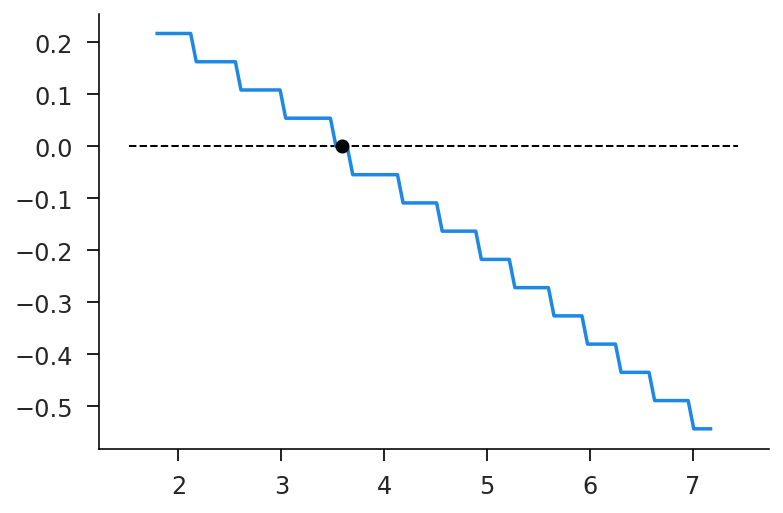

In [59]:
# make sure our policy function lines up with the analytic steady state
fig, ax = plt.subplots()
ax.plot(k_grid, ret['kp'][-1,:]-k_grid);
ax.hlines(0, *ax.get_xlim(), linestyle='--', linewidth=1, color='k')
ax.scatter(k_ss, 0, color='k', zorder=10);